# 21  Training Linear Classifiers with Logistic Regression
# 21. 1 Linearly Separating Customers By Size

In Section Fourteen, we simulated customer heights (in inches) and weights (in pounds). We’ll now proceed to re-run that simulation. For the purpose of this exercise, we’ll focus on the two classes; _Large_ and _Not Large_. We’ll assume that customers within the _Large_ class are taller than 72 inches and heavier than 160 lb.

**Listing 21. 1. Simulating Categorized Customer Measurements**

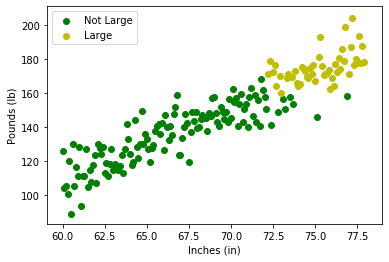

In [11]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

def plot_customers(X, y, xlabel='Inches (in)', ylabel='Pounds (lb)'):
    colors = ['g', 'y']
    labels = ['Not Large', 'Large']
    for i, (color, label) in enumerate(zip(colors, labels)):
        plt.scatter(X[:,0][y == i], X[:,1][y == i], color=color, label=label)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
inches = np.arange(60, 78, 0.1)
random_fluctuations = np.random.normal(scale=10, size=inches.size) 
pounds = 4 * inches - 130 + random_fluctuations
X = np.array([inches, pounds]).T
y = ((X[:,0] > 72) & (X[:,1] > 160)).astype(int)

plot_customers(X, y)
plt.legend()
plt.show()

We can image a knife slicing through the cigar-shaped plot, in order to separate the colors. The knife acts like a boundary that separates the two customer classes. We can represent this boundary using a line with slope of -3.5 and a y-intercept of 415.

**Listing 21. 2. Plotting a boundary to separate the two customer classes**

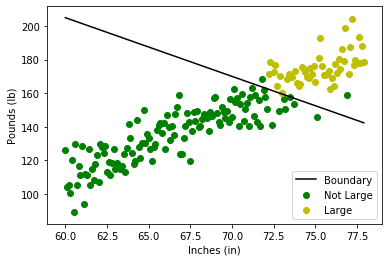

In [12]:
def boundary(inches): return -3.5 * inches + 415
plt.plot(X[:,0], boundary(X[:,0]), color='k', label='Boundary')
plot_customers(X, y)
plt.legend()
plt.show()

Most of the customers within the _Large_ class are located above the plotted line. Hence, we can use this line to classify the customers. Given a customer with measurement of `(inches, lbs)`, we predict the customer’s class by checking whether `lbs > -3.5 * inches + 415`. 

**Listing 21. 3. Predicting classes using a linear boundary**

In [13]:
from sklearn.metrics import f1_score
y_pred = []
for inches, lbs in X:
    prediction = int(lbs > -3.5 * inches + 415)
    y_pred.append(prediction)
    
f_measure = f1_score(y_pred, y)
print(f'The f-measure is {f_measure:.2f}')

The f-measure is 0.97


we can run the classification more concisely using vector dot products.

**Listing 21. 4. Predicting classes using vector dot products**

In [14]:
weights = np.array([3.5, 1, -415])
predictions = [int(weights @ [inches, lbs, 1] > 0) for inches, lbs in X]
assert predictions == y_pred

We can further consolidate our code if we use matrix multiplication.

**Listing 21. 5. Predicting classes using matrix multiplication**

In [25]:
M = np.column_stack([X, np.ones(X.shape[0])])
print("First five rows of our padded feature matrix are:")
print(np.round(M[:5], 2))

predictions = (M @ weights > 0).astype(int)
assert predictions.tolist() == y_pred

First five rows of our padded feature matrix are:
[[ 60.   126.24   1.  ]
 [ 60.1  104.28   1.  ]
 [ 60.2  105.52   1.  ]
 [ 60.3  100.47   1.  ]
 [ 60.4  120.25   1.  ]]


We've boiled down customer classification to a simple matrix-vector product. This matrix-product classifier is called a **linear classifier**.

**Listing 21. 6. Defining a linear classifier function**

In [6]:
def linear_classifier(X, weights):
    M = np.column_stack([X, np.ones(X.shape[0])])
    return (M @ weights > 0).astype(int)

predictions = linear_classifier(X, weights)
assert predictions.tolist() == y_pred

Linear classifiers check whether weighted features and a constant add-up to a value greater than zero. The constant-value, which is stored in `weights[-1]`, is referred to as the **bias**. Meanwhile, the remaining weights are called the **coefficients**.

## 21. 2 Training a Linear Classifier

We want to find a weight vector that optimizes class prediction on `X`. Lets start by setting `weights` to equal three random values.

**Listing 21. 7. Classification using random weights**

In [7]:
np.random.seed(0)
weights = np.random.normal(size=3)
y_pred = linear_classifier(X, weights)
f_measure = f1_score(y_pred, y)

print('We inputted the following random weights:')
print(np.round(weights, 2))
print(f'\nThe f-measure is {f_measure:.2f}')

We inputted the following random weights:
[1.76 0.4  0.98]

The f-measure is 0.43


As expected, our f-measure is terrible! We can gain insight into why by printing `y_pred`.

**Listing 21. 8. Outputting the predicted classes**

In [8]:
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


All our data-points are assigned a class label of 1! The product of our weights and each feature vector is always greater than zero. Hence, our weights must be too high. Lowering the weights will yield more _Class 0_ predictions.

**Listing 21. 9. Shifting the class predictions by lowering the weights**

In [9]:
assert np.all(linear_classifier(X, [0, 0, 0]) == 0)

We can intelligently raise and lower the weights until our predictions align with the actual class labels. Lets devise a strategy for adjusting the weights to match the labels. We'll start by adjusting the bias at `weights[-1]`. One simple strategy entails comparing each _predicted_ / _actual_ class-label pair.

**Listing 21. 10. Computing the bias shift based on prediction quality**

In [10]:
def get_bias_shift(predicted, actual):
    if predicted == actual:
        return 0
    if predicted > actual:
        return 1
        
    return -1

Mathematically, we can show that our `get_bias_shift` function is equivalent to `predicted - actual`.

**Listing 21. 11. Computing the bias shift using arithmetic**

In [11]:
for predicted, actual in [(0, 0), (1, 0), (0, 1), (1, 1)]:
    bias_shift = get_bias_shift(predicted, actual)
    assert bias_shift == predicted - actual

Rather than shifting the bias by a single unit, we can shift it 1/10th of a unit, or or 10 units or 100 units. The actual unit-shift can be controlled by a parameter called the **learning rate**. The learning rate is multiplied against `predicted - actual` in order to adjust the shift size.

**Listing 21. 12. Computing the bias shift with a learning rate**

In [12]:
def get_bias_shift(predicted, actual, learning_rate=0.1):
    return learning_rate * (predicted - actual)

We are ready to adjust our bias. Below, we'll iterate over each `[inches, lbs, 1]` vector in `M`. For every ith vector, we'll predict the class label and compare it to the actual class within `y[i]`. Using each prediction, we'll compute the bias shift, and subtract it from the bias.

**Listing 21. 13. Iteratively shifting the bias**

In [13]:
def predict(v, weights): return int(v @ weights > 0)

starting_bias = weights[-1]
for i, actual in enumerate(y):
    predicted = predict(M[i], weights)
    bias_shift = get_bias_shift(predicted, actual)
    weights[-1] -= bias_shift

new_bias = weights[-1]
print(f"Our starting bias equaled {starting_bias:.2f}.")
print(f"The adjusted bias equals {new_bias:.2f}.")

Our starting bias equaled 0.98.
The adjusted bias equals -12.02.


The bias has drastically decreased. Lets check whether the shift improved our f-measure.

**Listing 21. 14. Checking performance after the bias shift**

In [14]:
y_pred = linear_classifier(X, weights)
f_measure = f1_score(y_pred, y)
print(f'The f-measure is {f_measure:.2f}')

The f-measure is 0.43


Our f-measure remains the same. Simply adjusting the bias is insufficient. We need to adjust the coefficients as well but how? Naively, we could subtract the bias shift from every coefficient. Unfortunately, this naive approach is flawed. It always adjusts the coefficients. However, it is dangerous to adjust the coefficients when their associated features are equal to zero. Thus, we need to shift each coefficient by multiplying the bias shift with the coefficent's feature. In NumPy, we can do this by running `weights -= bias_shift * M[i]`.

**Listing 21. 15. Computing all weight-shifts in one line of code**

In [15]:
old_weights = weights.copy()
for i, actual in enumerate(y):
    predicted = predict(M[i], weights)
    bias_shift = get_bias_shift(predicted, actual)
    weights -= bias_shift * M[i]

y_pred = linear_classifier(X, weights)
f_measure = f1_score(y_pred, y)

print("The weights previously equaled:")
print(np.round(old_weights, 2))
print("\nThe updated weights now equal:")
print(np.round(weights, 2))
print(f'\nThe f-measure is {f_measure:.2f}')

The weights previously equaled:
[  1.76   0.4  -12.02]

The updated weights now equal:
[ -4.64   2.22 -12.12]

The f-measure is 0.78


Our f-measure has risen from 0.43 to 0.78. The weight shift strategy is working! Lets repeat the iteration 1000 times.

**Listing 21. 16. Tweaking the weights over multiple iterations**

The f-measure after 1000 iterations is 0.68


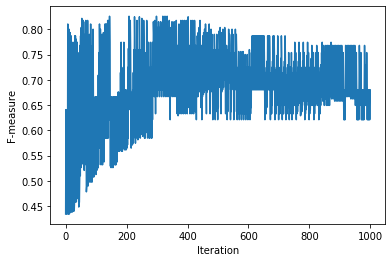

In [16]:
np.random.seed(0)
weights = np.random.normal(size=3)

f_measures = []
for _ in range(1000):
    y_pred = linear_classifier(X, weights)
    f_measures.append(f1_score(y_pred, y))

    for i, actual in enumerate(y):
        predicted = predict(M[i], weights)
        bias_shift = get_bias_shift(predicted, actual)
        weights -=  bias_shift * M[i]

print(f'The f-measure after 1000 iterations is {f_measures[-1]:.2f}')
plt.plot(range(len(f_measures)), f_measures)
plt.xlabel('Iteration')
plt.ylabel('F-measure')
plt.show()

The classifier performance oscillates wildly over the course of the iterations.The rapid fluctuations are caused by a weight shift that is consistently too high. We should slowly lower the weight shift over each additional iteration. We can do this by dividing the weight shift by `k` for each _kth_ iteration.

**Listing 21. 17. Reducing weight shifts over multiple iterations**

The f-measure after 1000 iterations is 0.82


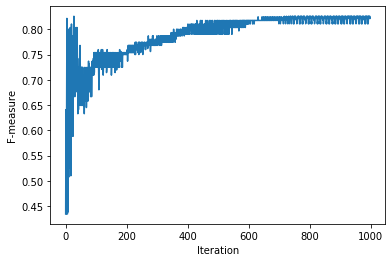

In [17]:
np.random.seed(0)
def train(X, y,
          predict=predict):
    M = np.column_stack([X, np.ones(X.shape[0])])
    weights = np.random.normal(size=X.shape[1] + 1)
    f_measures = []
    for k in range(1, 1000):
        y_pred = linear_classifier(X, weights)
        f_measures.append(f1_score(y_pred, y))

        for i, actual in enumerate(y):
            predicted = predict(M[i], weights)
            bias_shift = get_bias_shift(predicted, actual)
            weights -=  bias_shift * M[i] / k
    
    return weights, f_measures

weights, f_measures = train(X, y)
print(f'The f-measure after 1000 iterations is {f_measures[-1]:.2f}')
plt.plot(range(len(f_measures)), f_measures)
plt.xlabel('Iteration')
plt.ylabel('F-measure')
plt.show()


Our gradual weight-shift reduction was successful. The f-measure converges to a steady value of 0.82. We achieved convergence using a **Perceptron training algorithm**. Through repetition, the Perceptron training algorithm will eventually converge to a steady f-measure. However, that f-measure will not necessarily be optimal. For instance, our Perceptron converged to an f-measure of 0.82.  The level of performance doesn't match our initial result of 0.97. Our new decision boundary doesn't separate the data as well as our old decision boundary. Lets check how the two boundaries visually compare.

**Listing 21. 18. Comparing new and old decision boundaries**

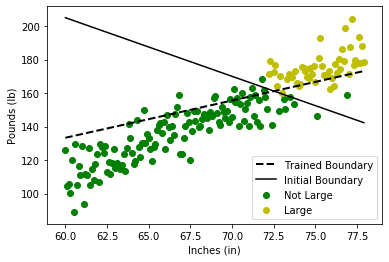

In [18]:
inches_coef, lbs_coef, bias = weights
def new_boundary(inches): 
    return -(inches_coef * inches + bias) / lbs_coef

plt.plot(X[:,0], new_boundary(X[:,0]), color='k', linestyle='--', 
         label='Trained Boundary', linewidth=2)
plt.plot(X[:,0], boundary(X[:,0]), color='k', label='Initial Boundary')
plot_customers(X, y)
plt.legend()
plt.show()

Our linear boundary is inferior to our initial linear boundary. Our training is hindered by large, fluctuating features in matrix `X`. We can limit this impediment through a process called **standardization**, in which `X` is adjusted to equal `(X - X.mean(axis=0)) / X.std(axis=0)`.

### 21.2.1 Improving Linear Classification with Logistic Regression Improving Perceptron Performance through Standardization 
Our training lacks all nuance because the coefficient shifts are way too high. However, we can lower these shifts by lowering column means in matrix `X`. Additionally, we’ll need to lower the dispersion in the matrix. To start, lets print the current values of `X.mean(axis=0)` and `X.std(axis=0)`.

**Listing 21. 19. Printing feature means and standard deviations**

In [19]:
means = X.mean(axis=0)
stds = X.std(axis=0)
print(f"Mean values: {np.round(means, 2)}")
print(f"STD values: {np.round(stds, 2)}")

Mean values: [ 68.95 146.56]
STD values: [ 5.2  23.26]


The feature means and standard deviations are relatively high. We can shift the means to zero by subtracting `means` from `X`. Additionally, we can shift the standard deviations to 1.0 by running `(X - means) / stds`. This simple process is called **standardization**.

**Listing 21. 20. Standardizing the feature matrix**

In [20]:
def standardize(X):
    return (X - means) / stds

X_s = standardize(X)
assert np.allclose(X_s.mean(axis=0), 0)
assert np.allclose(X_s.std(axis=0), 1)

We'll now check whether training on the standardized feature matrix improves our results.

**Listing 21. 21. Training on the standardized feature matrix**

After standardization, the f-measure is 0.98


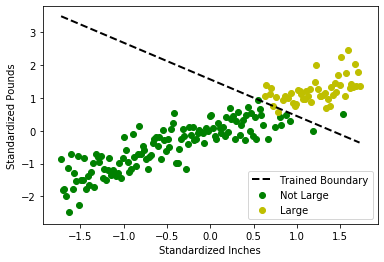

In [23]:
np.random.seed(0)
weights, f_measures = train(X_s, y)
print(f'After standardization, the f-measure is {f_measures[-1]:.2f}')

def plot_boundary(weights):
    a, b, c = weights
    new_boundary = lambda x: -(a * x + c) / b
    plt.plot(X_s[:,0], new_boundary(X_s[:,0]), color='k', linestyle='--', 
         label='Trained Boundary', linewidth=2)
    plot_customers(X_s, y, xlabel='Standardized Inches', 
                   ylabel='Standardized Pounds')
    plt.legend()
    plt.show()
    
plot_boundary(weights)

In [ ]:
1/0

We achieved improvement in performance through standardization. However, our trained classifier now requires all input data to be standardized prior to classification. Hence, given any new data `d`, we will need to classify that data by running `linear_classifier(standardize(d), weights)`. 

**Listing 21. 22. Standardizing new classifier inputs**

In [24]:
new_data = np.array([[63, 110], [76, 199]])
predictions = linear_classifier(standardize(new_data), weights)
print(predictions)

[0 1]


We’ve standardized our data and achieved a very high level of Perceptron performance. Unfortunately, this optimal f-measure is still not guaranteed by the training algorithm. Trained Perceptron quality can fluctuate, even if the algorithm is run repeatedly on the same training set. 

**Listing 21. 23. Checking a Perceptron’s training consistency**

In [25]:
np.random.seed(0)
poor_train_count = sum([train(X_s, y)[1][-1] < 0.97 for _ in range(5)])
print("The f-measure fell below our baseline of 0.97 in "
      f"{poor_train_count} out of 5 training instances")

The f-measure fell below our baseline of 0.97 in 4 out of 5 training instances


In 80% of instances, the trained model performance falls below the baseline. Our basic perceptron model is clearly flawed. We'll address these flaws in the subsequent subsection using Logistic regression.

## 21.3 Improving Linear Classification with Logistic Regression

Not all predictions should be treated equally. Sometimes, we are more confident in some predictions over others. 
Class confidence is determined by the distance from the decision boundary.  It’s also determined by position relative to the boundary.  We can capture both distance and position with **directed distance**. We need a function that rises from 0 to 1.0 as directed distances rises from negative infinity to infinity. Also, the function should equal 0.5 when the distance is 0. Within this book, we have encountered one such function; the cumulative distribution function of the Normal curve.

**Listing 21. 24. Measuring uncertainty using stats.norm.cdf**

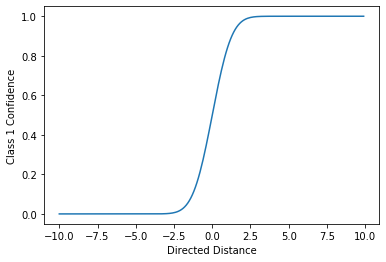

In [26]:
from scipy import stats
z = np.arange(-10, 10, 0.1)
assert stats.norm.cdf(0.0) == 0.5
plt.plot(z, stats.norm.cdf(z))
plt.xlabel('Directed Distance')
plt.ylabel('Class 1 Confidence')
plt.show()

We can also generate and S-shaped plot using the the **logistic** curve. The logistic function of `z` is `1 / (1 - e ** z)` where `e` is a constant equal to approximately 2.72. 

**Listing 21. 25. Measuring uncertainty using the logistic curve**

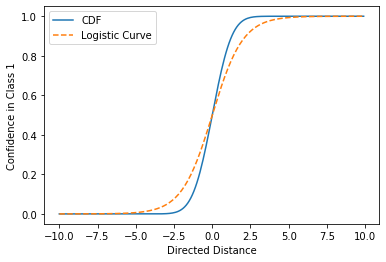

In [27]:
from math import e
plt.plot(z, stats.norm.cdf(z), label='CDF')
plt.plot(z, 1 / (1 + e ** -z), label='Logistic Curve', linestyle='--')
plt.xlabel('Directed Distance')
plt.ylabel('Confidence in Class 1')
plt.legend()
plt.show()

We use the logistic curve as our measure of uncertainty. Lets utilize the curve to assign _Class 1_ label likelihoods for all our customers. The product `M @ weights` returns the directed distances to the boundary. Hence,  `1 / (1 + e ** -(M @ weights)`, returns the _Class 1_ likelihoods. Below, we’ll plot these likelihoods, along with the binary Perceptron predictions.

**Listing 21. 26. Comparing logistic uncertainty to the Perceptron’s predictions**

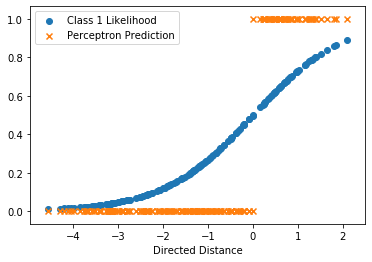

In [28]:
M = np.column_stack([X_s, np.ones(X_s.shape[0])])
distances = M @ weights
likelihoods = 1 / (1 + e ** -distances)
plt.scatter(distances, likelihoods, label='Class 1 Likelihood')
plt.scatter(distances, distances > 0, 
            label='Perceptron Prediction', marker='x')

plt.xlabel('Directed Distance')
plt.legend()
plt.show()

The plotted logistic likelihoods continuously increase with directed distance. In contrast, the Perceptron predictions are brutishly simple. The model is overconfident. It is bound to make mistakes! We can teach the model caution by incorporating the uncertainty that's captured by the logistic curve.

**Listing 21. 27. Incorporating uncertainty into training**

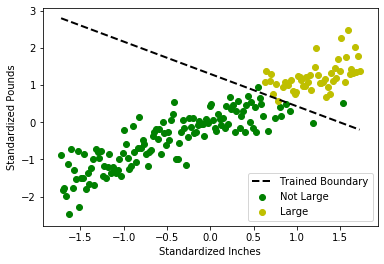

In [29]:
np.random.seed(0)
def logistic_predict(v, weights): return 1 / (1 + e ** -(weights @ v))
def train_logistic(X, y): return train(X, y, predict=logistic_predict)
logistic_weights = train_logistic(X_s, y)[0]
plot_boundary(logistic_weights)

The learned decision boundary is nearly identical to that of the Perceptron output. However, our `train_logistic` function is subtly different. It produces more consistent results than the Perceptron.

**Listing 21. 28. Checking the logistic model’s training consistency**

In [30]:
np.random.seed(0)
poor_train_count = sum([train_logistic(X_s, y)[1][-1] < 0.97
                        for _ in range(5)])
print("The f-measure fell below our baseline of 0.97 in "
      f"{poor_train_count} out of 5 training instances")

The f-measure fell below our baseline of 0.97 in 0 out of 5 training instances


The trained model does not fall below the baseline in any of the runs. Hence, it is superior to the Perceptron. This superior model is called a **Logistic regression classifier**.

## 21.3.1 Running Logistic Regression on More than Two Features

Our `train_logistic` function can process any number of input features. We’ll prove this by adding a third feature; customer waist circumference.

**Listing 21. 29. Training a three-feature Logistic regression model**

In [31]:
np.random.seed(0)
random_fluctuations = np.random.normal(size=X.shape[0], scale=0.1)
waist = 0.45 * X[:,0] + random_fluctuations
X_w_waist =  np.column_stack([X_s, (waist - waist.mean()) / waist.std()])
weights, f_measures = train_logistic(X_w_waist, y)

print("Our trained model has the following weights:")
print(np.round(weights, 2))
print(f'\nThe f-measure is {f_measures[-1]:.2f}')

Our trained model has the following weights:
[ 1.65  2.91  1.26 -4.08]

The f-measure is 0.97


## 21. 3 Training Linear Classifiers Using Scikit-Learn

Scikit-Learn has a built-in class  Logistic regression class.

**Listing 21. 31. Initializing Scikit-Learn’s `LogisticRegression` classifier**

In [2]:
from sklearn.linear_model import LogisticRegression

Next, we'll initialize the classifier object `clf`.

**Listing 21. 32. Initializing Scikit-Learn's `LogisticRegression` classifier**

In [4]:
clf = LogisticRegression()

As discussed in Section Twenty, we can train any `clf` by running `clf.predict(X, y)`.

**Listing 21. 33. Training Scikit-Learn’s LogisticRegression classifier**

In [34]:
clf.fit(X_s, y)

LogisticRegression()

The trained model's coefficients are stored within the `clf.coef_` attribute. Meanwhile, the bias must be accessed separately, using the `clf.intercept_` attribute. Combining these attributes will give us the full weight vector, which can be visualized as a decision boundary.

**Listing 21. 33. Accessing the trained decision boundary**

The coefficients equal [[2.22 3.22]]
The bias equals [-3.96]


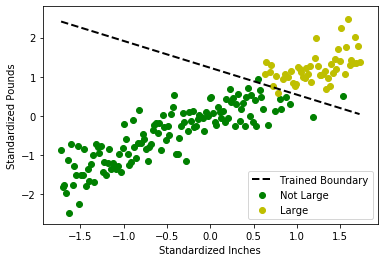

In [35]:
coefficients = clf.coef_
bias = clf.intercept_
print(f"The coefficients equal {np.round(coefficients, 2)}")
print(f"The bias equals {np.round(bias, 2)}")    
plot_boundary(np.hstack([clf.coef_[0], clf.intercept_]))

We can make predictions on new data by executing `clf.predict`. As the reminder, the inputted data must be standardized for our predictions to make sense.

**Listing 21. 34. Predicting classes with the linear classifier**

In [36]:
new_data = np.array([[63, 110], [76, 199]])
predictions = clf.predict(standardize(new_data))
print(predictions)

[0 1]


Additionally, we can output the class-label probabilities by running `clf.predict_proba`. These probabilities represent the class-label uncertainties generated by the logistic curve.

**Listing 21. 35. Outputting the uncertainty associated with each class**

In [37]:
probabilities = clf.predict_proba(standardize(new_data))
print(probabilities)

[[9.99990471e-01 9.52928118e-06]
 [1.80480919e-03 9.98195191e-01]]


We've relied on a custom`standardize` function to standardize our input data. Scikit-Learn includes its own standardization class called `StandardScaler`.

**Listing 21. 36. Initializing Scikit-Learn’s standardization class**

In [3]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

Running `standard_scaler.fit_transform(X)` will return a standardized matrix.

**Listing 21. 37. Standardizing training data using Scikit-Learn**

In [39]:
X_transformed = standard_scaler.fit_transform(X)
assert np.allclose(X_transformed.mean(axis=0), 0)
assert np.allclose(X_transformed.std(axis=0), 1)
assert np.allclose(X_transformed, X_s)

The `standard_scaler` object has learned the means and standard deviations associated with our feature matrix. Hence, it can now standardize data based on these statistics. 

**Listing 21. 38. Standardizing new data using Scikit-Learn**

In [40]:
data_transformed = standard_scaler.transform(new_data)
assert np.array_equal(clf.predict(data_transformed), predictions)

By combining the `LogisticRegression` and `StandardScaler` classes, we can train Logistic models on complex inputs. In the next subsection, we'll train a model that can process more than two features and can predict more than two class labels.

### 21.4.1 Training Multi-Class Linear Models

We’ve shown how linear classifiers can find decision boundaries that separate two classes of data. However, many problems require us to differentiate between more than two classes. We'll now attempt to train a classifier that can distinguish between multiple classes of wine. First, we'll load the appropriate data from Scikit-Learn.

**Listing 21. 39. Importing Scikit-Learn’s wine dataset**

In [6]:
from sklearn.datasets import load_wine
data = load_wine()
feature_names = data.feature_names
num_classes = len(data.target_names)
num_features = len(data.feature_names)
print(f"The wine dataset contains {num_classes} classes of wine:")
print(data.target_names)
print(f"\nIt contains the {num_features} features:")
print(data.feature_names)

The wine dataset contains 3 classes of wine:
['class_0' 'class_1' 'class_2']

It contains the 13 features:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


If we train our Logistic regression pipeline on the three-class wine data, we'll obtain three decision boundaries. Thee three biases associated with these bounaderies will be stored in the `clf.intercept_` array. 

**Listing 21. 40. Training a multi-class wine predictor**

In [7]:
X, y = load_wine(return_X_y=True)
clf.fit(standard_scaler.fit_transform(X), y)
biases = clf.intercept_

print(f"We trained {biases.size} decision boundaries, corresponding to "
      f"the {num_classes} classes of wine.\n")

for i, bias in enumerate(biases):
    label = data.target_names[i]
    print(f"The {label} decision boundary has a bias of {bias:0.2f}")

We trained 3 decision boundaries, corresponding to the 3 classes of wine.

The class_0 decision boundary has a bias of 0.41
The class_1 decision boundary has a bias of 0.70
The class_2 decision boundary has a bias of -1.12


The coefficients across the three different boundaries can be stored in a 3-by-13 matrix. In Scikit-Learn, that matrix is contained within `clf.coef_` Each _ith_ row of the matrix corresponds to the boundary of _Class i_. Meanwhile, each _jth_ column corresponds to the _jth_ feature coefficient. We can visiualize these relationships using a heatmap.

**Listing 21. 41. Displaying a transpose of the coefficient matrix**

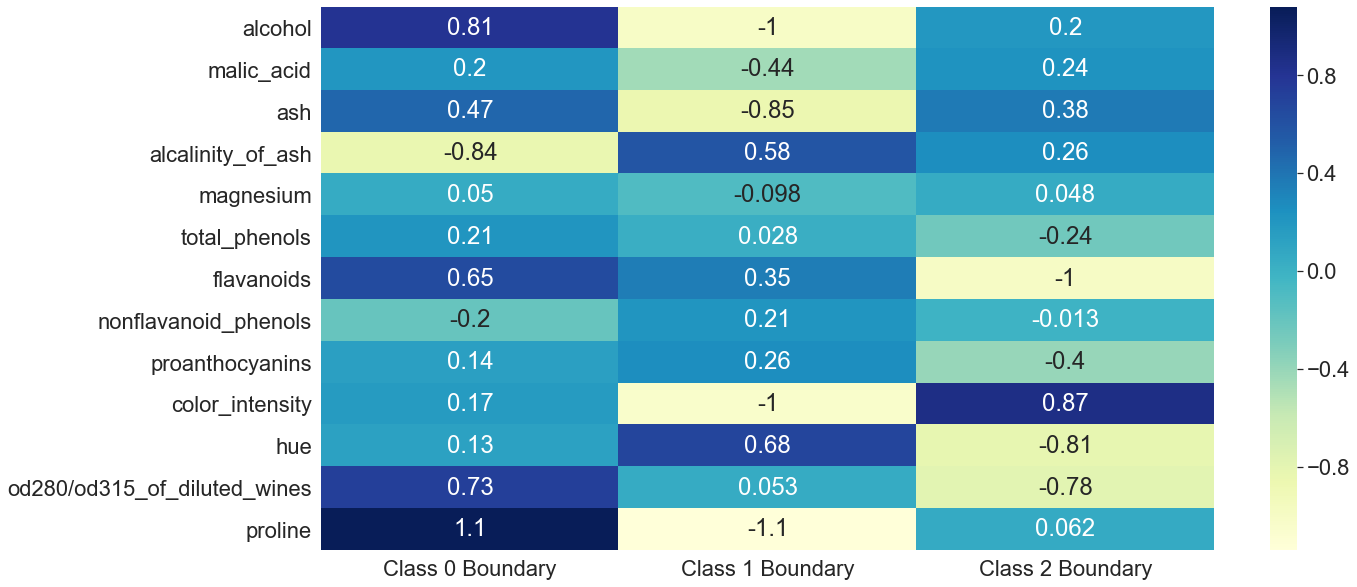

In [44]:
import seaborn as sns
plt.figure(figsize = (20, 10))
coefficients = clf.coef_

sns.heatmap(coefficients.T, cmap='YlGnBu', annot=True, 
            xticklabels=[f"Class {i} Boundary" for i in range(3)],
            yticklabels=data.feature_names) 
plt.yticks(rotation=0)

plt.show()

## 21. 5 Measuring Feature Importance with Coefficients

Features can be rated by their coefficients in order to assess their **feature importance**. The feature importance is a score that ranks the usefulness of features during classification. In linear classifiers, the absolute values of the coefficients serve as crude measures of importance. What feature is most useful for correctly detecting a _Class 0_ wine? We can check by sorting the features based on the absolute values of the _Class 0_ coefficients in `clf.coef_[0]`.

**Listing 21. 42. Ranking Class 0 features by feature importance**

In [45]:
def rank_features(class_label):
    absolute_values = np.abs(clf.coef_[class_label])
    for i in np.argsort(absolute_values)[::-1]:
        name = data.feature_names[i]
        coef = clf.coef_[class_label][i]
        print(f"{name}: {coef:.2f}")

rank_features(0)

proline: 1.08
alcalinity_of_ash: -0.84
alcohol: 0.81
od280/od315_of_diluted_wines: 0.73
flavanoids: 0.65
ash: 0.47
total_phenols: 0.21
malic_acid: 0.20
nonflavanoid_phenols: -0.20
color_intensity: 0.17
proanthocyanins: 0.14
hue: 0.13
magnesium: 0.05


Proline concentration is the most important feature for identifying _Class 0_ wines. Now, lets check which feature drives _Class 1_ wine identification.

**Listing 21. 43. Ranking Class 1 features by importance**

In [46]:
rank_features(1)

proline: -1.14
color_intensity: -1.04
alcohol: -1.01
ash: -0.85
hue: 0.68
alcalinity_of_ash: 0.58
malic_acid: -0.44
flavanoids: 0.35
proanthocyanins: 0.26
nonflavanoid_phenols: 0.21
magnesium: -0.10
od280/od315_of_diluted_wines: 0.05
total_phenols: 0.03


Proline concentration is the most important feature for both _Class 0_ and _Class 1_ wines.  The _Class 0_ coefficient is positive  while the _Class 1_ coefficient is negative. Positive coefficients increase the weighted sum of linear values, while negative values decrease that sum. Thus, a high proline concentration implies that: 

1. A wine is less likely to a _Class 1_ wine.
2. wine is more likely to be a _Class 0_ wine.

We can check our hypothesis by plotting histograms of proline concentration for the two classes of wine.

**Listing 21. 44. Plotting proline histograms across _Class 0_ and _1_ wines**

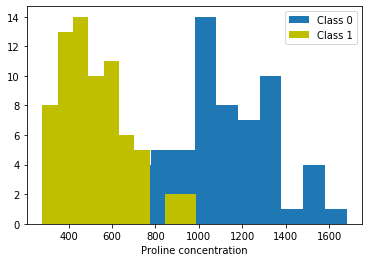

In [8]:
index = data.feature_names.index('proline')
plt.hist(X[y == 0][:, index], label='Class 0')
plt.hist(X[y == 1][:, index], label='Class 1', color='y')
plt.xlabel('Proline concentration')
plt.legend()
plt.show()

## 21. 6 Linear Classifier Limitations

The most serious limitation of linear classifiers is right there in the name; linear classifiers learn _linear_ decision boundaries. However, there are countless classification problems that are not linearly separable. Consider for example, the problem of classifying urban and non-urban households. Lets assume prediction is driven by the distance to the city center. Below, we'll simulate these households and then search for an optimal decision boundary. Unfortunately, we'll fail in our efforts.

**Listing 21. 45. Simulating a non-linearly separable scenario**

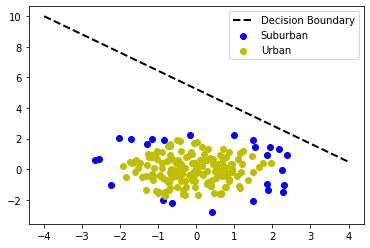

In [10]:
np.random.seed(0)
X = np.array([[np.random.normal(), np.random.normal()]
              for _ in range(200)]) 
y = (np.linalg.norm(X, axis=1) < 2).astype(int)

clf = LogisticRegression()
clf.fit(X, y)
weights = np.hstack([clf.coef_[0], clf.intercept_])

a, b, c = weights
boundary = lambda x: -(a * x + c) / b
plt.plot(range(-4, 5), boundary(range(-4, 5)),  color='k', linestyle='--', 
                                linewidth=2, label='Decision Boundary')
for i in [0, 1]:
    plt.scatter(X[y == i][:, 0], X[y == i][:, 1],
                label= ['Suburban', 'Urban'][i],
                color=['b', 'y'][i])

plt.legend()
plt.show()